### IMPORTS

In [29]:
# IMPORTS
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import imblearn as imb

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to split the data
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from custom_adaboost import *

# to evaluate the models
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import learning_curve , cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Some functions
from utils import *

### ***2. Machine Learning Methods:***
#### 2.1. Apply at least 3 different machine learning methods
##### Apply at least 3 different machine learning methods on your selected problem. The methods should be selected from the ones covered in the course. None of the methods are allowed to be deep learning. For each method, you should test the effect of the hyperparameters and try to find a set of hyperparameter values that work well for your problem 
##### 2.2. You should apply all the concepts you learned in the course (such as Generalization and Combating Overfitting)
Our problem is a binary classification problem , and the labels are in the target column => Supervised Learning and Classification

#### Split Data to Train & Test

In [3]:
# Read the original dataset
dataset = pd.read_csv('./dataset/final_dataset.csv')

# separate the features and labels
labels = dataset['Diabetes_binary']
features = dataset.drop('Diabetes_binary', axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Read the resampled dataset
resampled_dataset = pd.read_csv('./dataset/resampled_dataset.csv')

# separate the features and labels
labels_resampled = resampled_dataset['Diabetes_binary']
features_resampled = resampled_dataset.drop('Diabetes_binary', axis=1)

x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(features_resampled, labels_resampled, test_size=0.3, random_state=42)

# Method 1: Logistic Regression Model

### A-Simple Model

##### Normal Data (Imbalanced)

In [20]:
#################################################### Model Training ####################################################
#Build simple model. No parameter's Tuning
lr_model = LogisticRegression(max_iter=40000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=40000)

Training Accuracy:86.1761
Testing Accuracy:86.3174
Confusion Matrix: 
 [[64236  1369]
 [ 9044  1455]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     65605
           1       0.52      0.14      0.22     10499

    accuracy                           0.86     76104
   macro avg       0.70      0.56      0.57     76104
weighted avg       0.83      0.86      0.83     76104



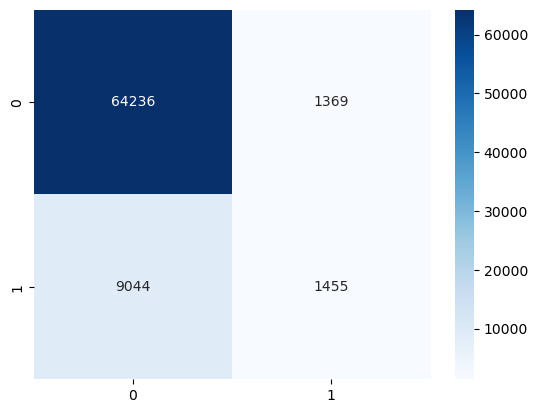

AUC: 0.8113


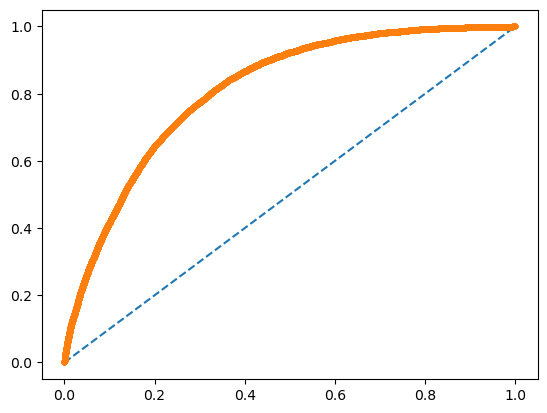

In [21]:
#################################################### Model Evaluation ####################################################
# Evaluate model
y_pred_train = lr_model.predict(x_train)
y_pred_test = lr_model.predict(x_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print("Training Accuracy:%.4f" % (train_accuracy*100))
print("Testing Accuracy:%.4f" % (test_accuracy*100))
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", class_report)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

#ROC-AUC Curve
# predict probabilities and keep postive outcomes only
probs = lr_model.predict_proba(x_test)
probs = probs[:, 1]

# AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.show()


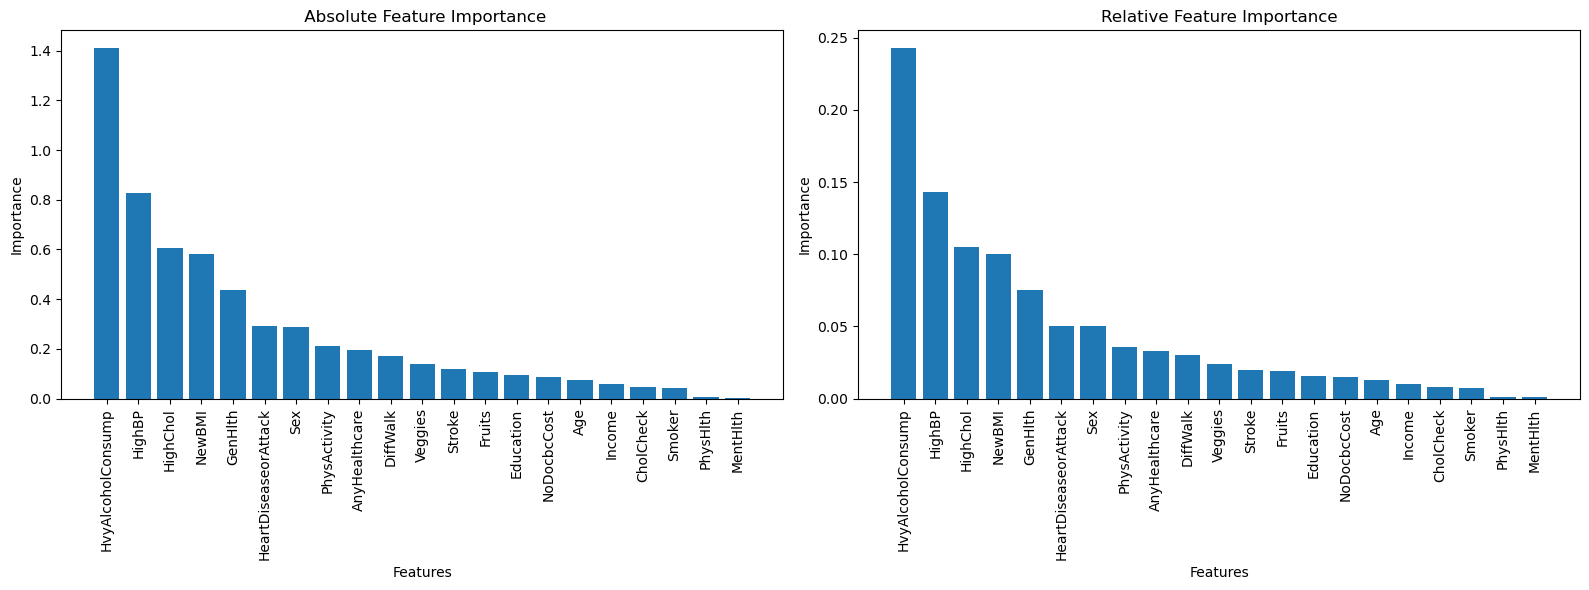

In [6]:
#################################################### Feature's Importance ####################################################
#1-Absolute Feature Importance
feature_importance = {}
for idx, feature_name in enumerate(features):
	importance = abs(lr_model.coef_[0][idx]).round(3)  # Get the absolute value of the coefficient
	feature_importance[feature_name] = importance
sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

# Extract feature names and importances
features_plot_x = list(sorted_feature_importance.keys())
importances_plot_y = list(sorted_feature_importance.values())

plt.figure(figsize=(16, 6))  
plt.subplot(1, 2, 1) 
plt.bar(features_plot_x, importances_plot_y)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(' Absolute Feature Importance')

#2-Relative Feature Importance
# Calculate total importance
total_importance = sum(importances_plot_y)
relative_importances = [(importance / total_importance).round(3) for importance in importances_plot_y]

plt.subplot(1, 2, 2)
plt.bar(features_plot_x, relative_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Feature Importance')

plt.tight_layout() 
plt.show()

# print("Feature Importance (Absolute): ", relative_importances)

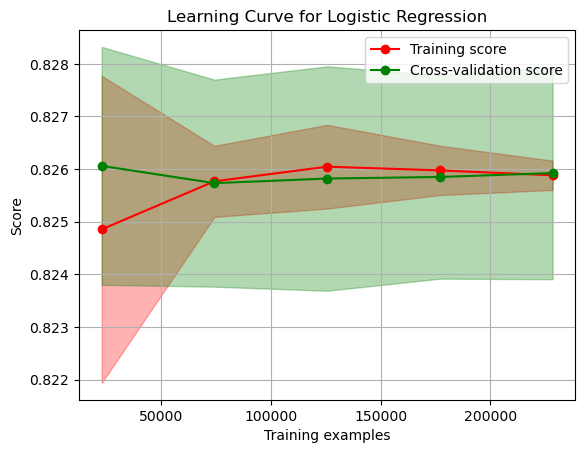

In [22]:
# Get the learning curve plot
train_sizes, train_scores, test_scores = learning_curve(lr_model, features, labels, cv=10,
                                                            train_sizes=np.linspace(.1, 1.0, 5),
                                                            scoring='f1_weighted', shuffle=True, random_state=42)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
					train_scores_mean + train_scores_std, alpha=0.3, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
					test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
			label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
			label="Cross-validation score")

plt.legend(loc='best')
plt.show()

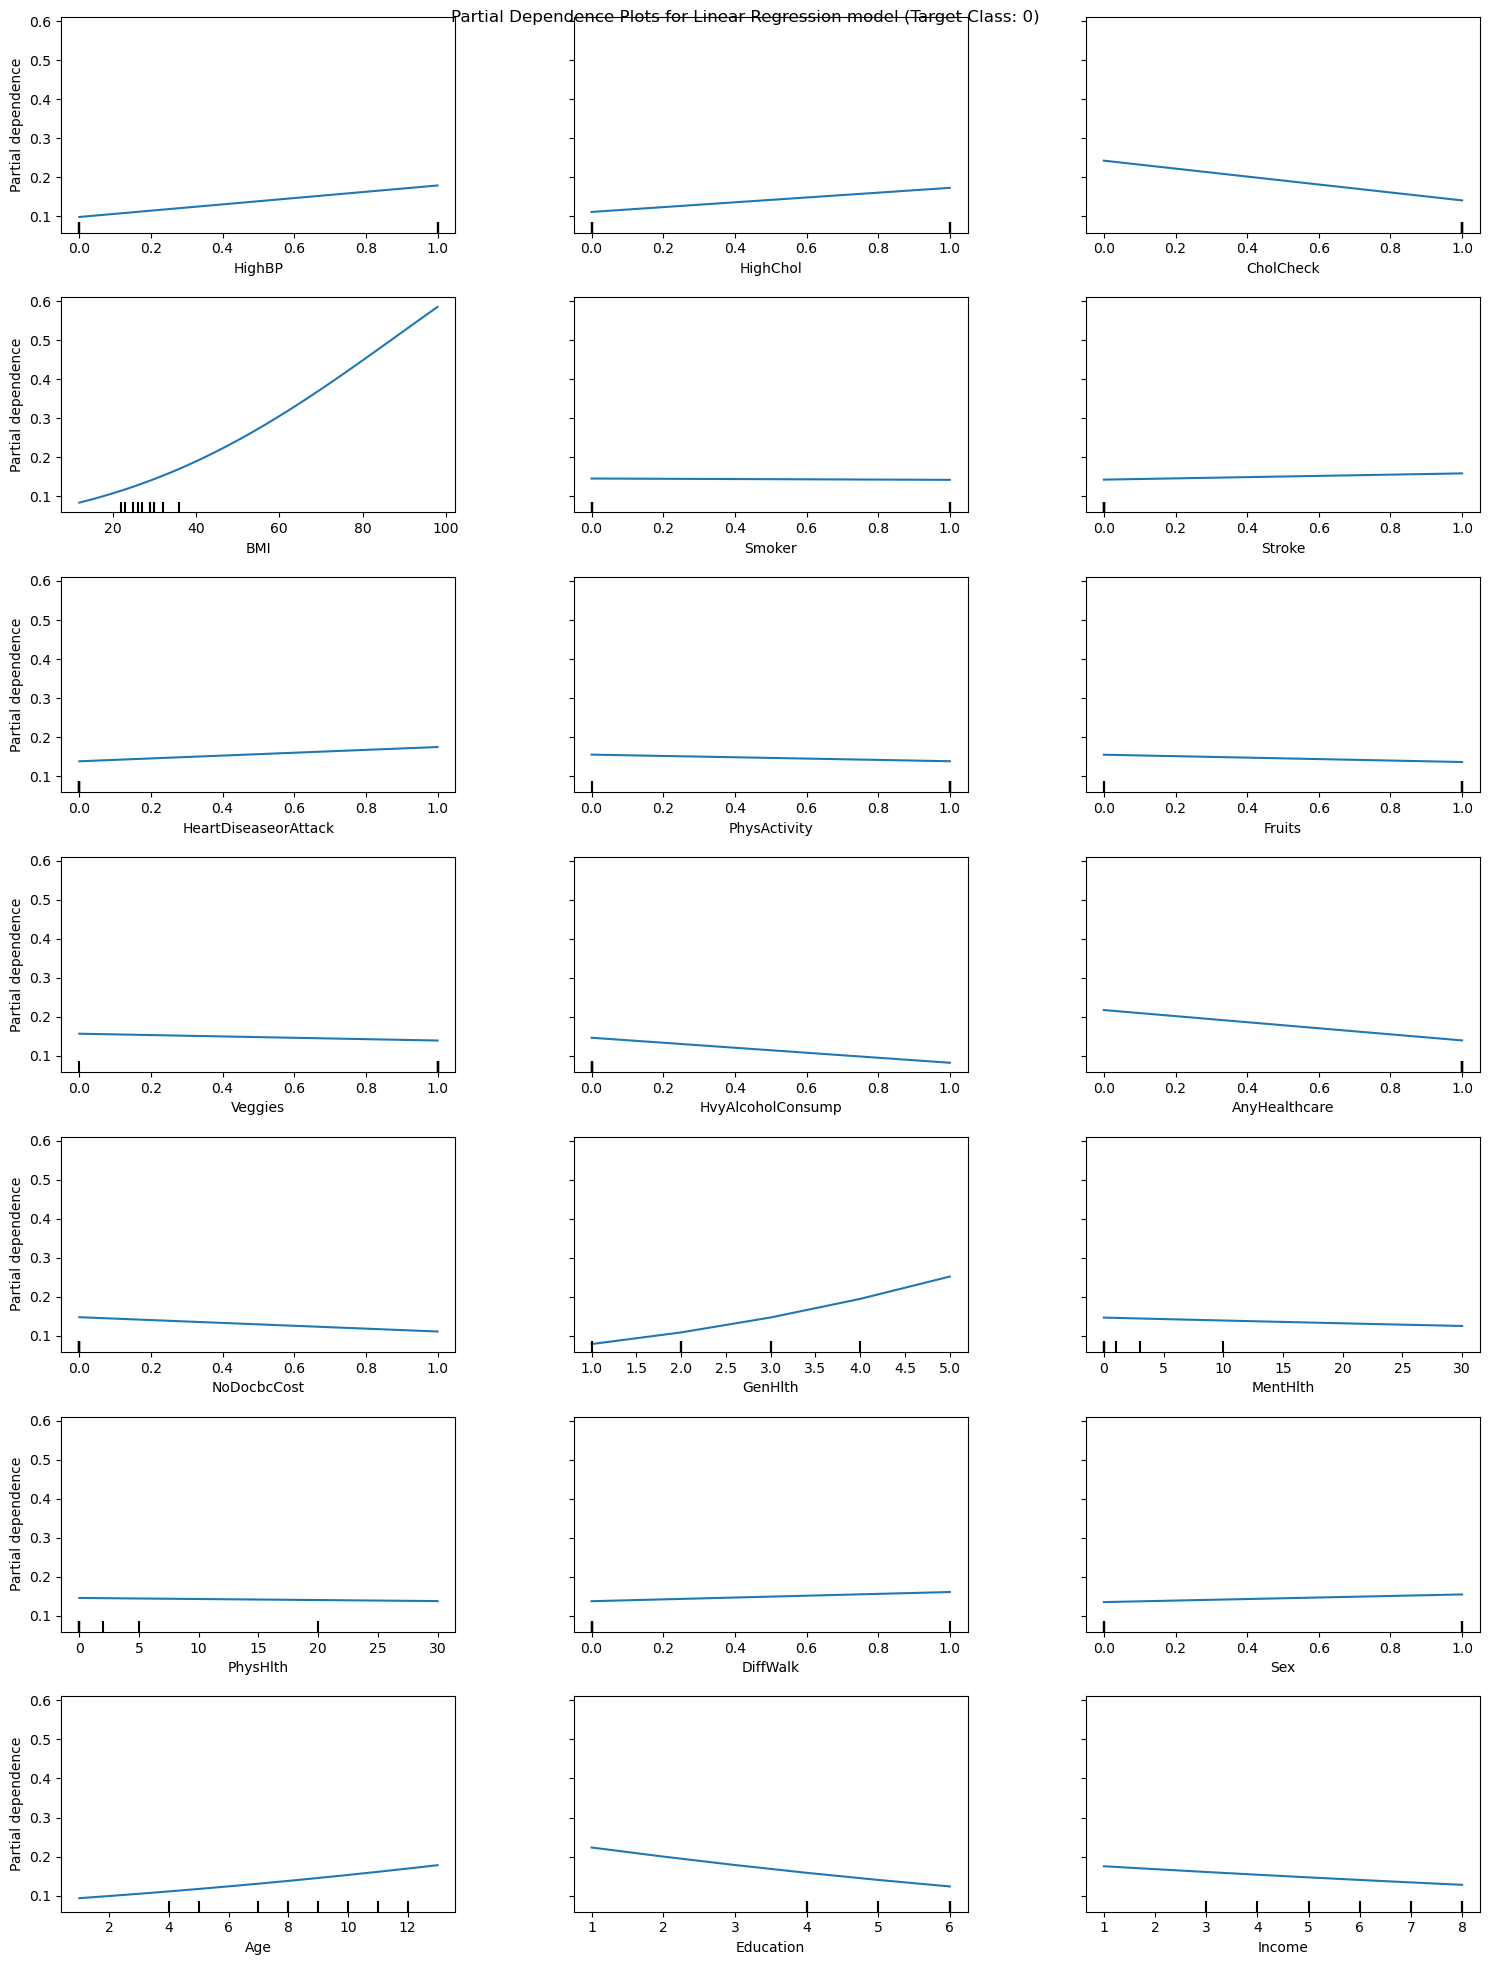

In [ ]:
# Model's Features Dependencies
'''
This is to show the relationship between a feature and the model's predictions (with all other features constant)

'''
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(15, 20), )
target_class = 0  # specify the target class
PartialDependenceDisplay.from_estimator(
	lr_model, features, features.columns, ax=ax, target=target_class)

# Increase spacing between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle(f'Partial Dependence Plots for Linear Regression model (Target Class: {target_class})')
fig.tight_layout()
plt.show()


##### Balanced Data 

In [ ]:
#################################################### Model Training ####################################################
#Build simple model. No parameter's Tuning
lr_model = LogisticRegression(max_iter=40000)
lr_model.fit(x_train_resampled, y_train_resampled)

LogisticRegression(max_iter=40000)

Training Accuracy:71.4793
Testing Accuracy:71.4838
Confusion Matrix: 
 [[46802 18803]
 [ 2899  7600]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     65605
           1       0.29      0.72      0.41     10499

    accuracy                           0.71     76104
   macro avg       0.61      0.72      0.61     76104
weighted avg       0.85      0.71      0.76     76104



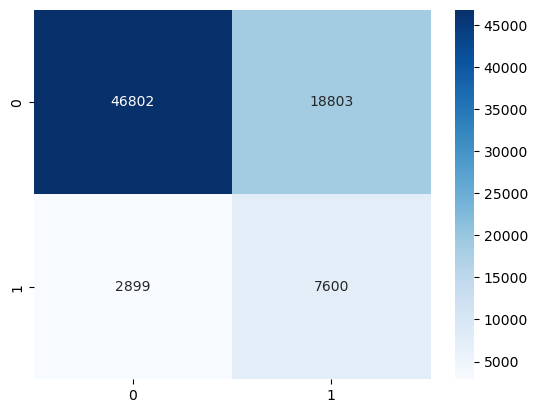

AUC: 0.7860


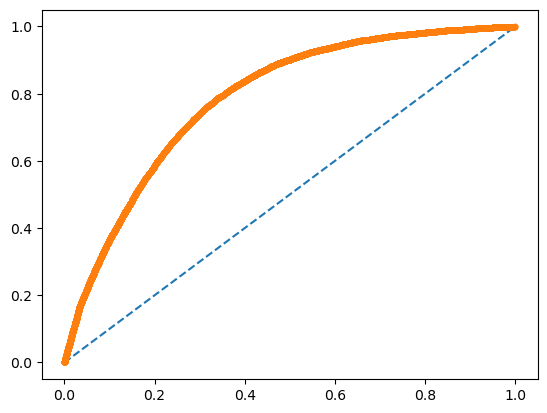

In [ ]:
#################################################### Model Evaluation ####################################################
# Evaluate model
y_pred_train = lr_model.predict(x_train_resampled)
y_pred_test = lr_model.predict(y_train_resampled)

train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test_resampled, y_pred_test)
conf_matrix = confusion_matrix(y_test_resampled, y_pred_test)
class_report = classification_report(y_test_resampled, y_pred_test)

print("Training Accuracy:%.4f" % (train_accuracy*100))
print("Testing Accuracy:%.4f" % (test_accuracy*100))
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", class_report)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

#ROC-AUC Curve
# predict probabilities and keep postive outcomes only
probs = lr_model.predict_proba(x_test)
probs = probs[:, 1]

# AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.show()


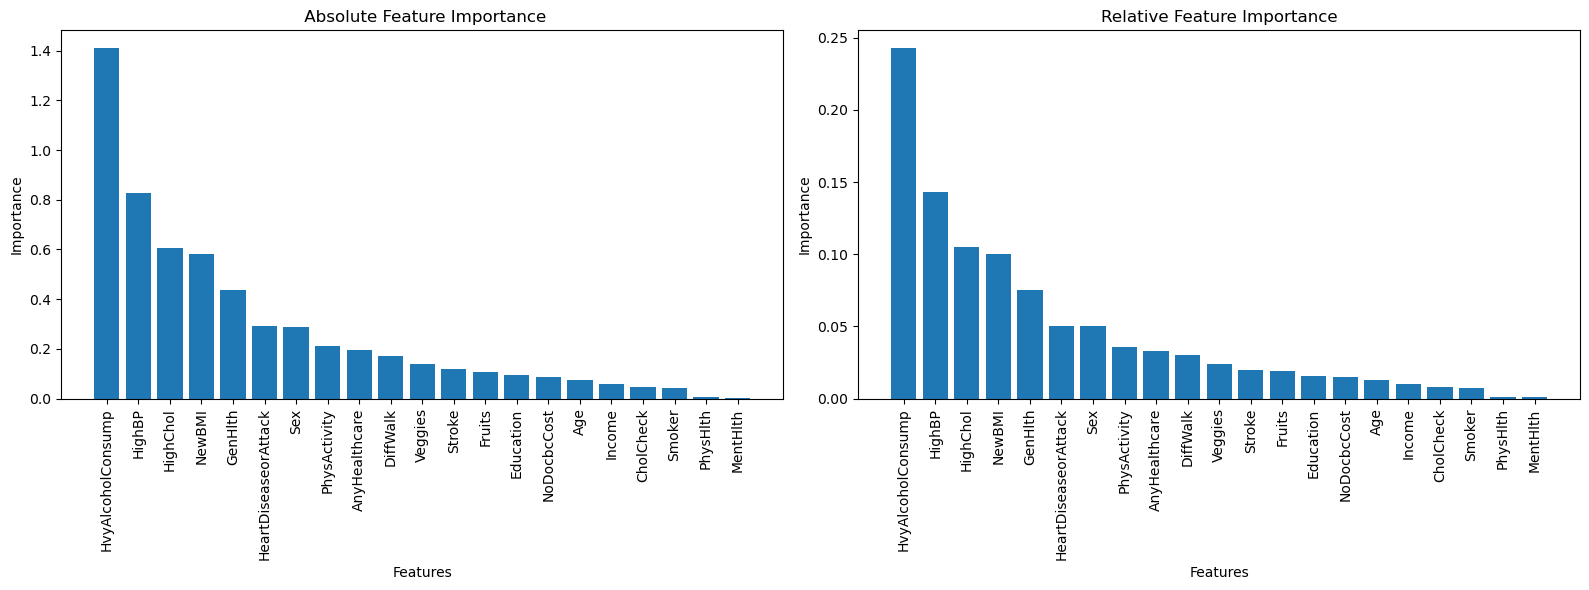

In [ ]:
#################################################### Feature's Importance ####################################################
#1-Absolute Feature Importance
feature_importance = {}
for idx, feature_name in enumerate(features):
	importance = abs(lr_model.coef_[0][idx]).round(3)  # Get the absolute value of the coefficient
	feature_importance[feature_name] = importance
sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

# Extract feature names and importances
features_plot_x = list(sorted_feature_importance.keys())
importances_plot_y = list(sorted_feature_importance.values())

plt.figure(figsize=(16, 6))  
plt.subplot(1, 2, 1) 
plt.bar(features_plot_x, importances_plot_y)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(' Absolute Feature Importance')

#2-Relative Feature Importance
# Calculate total importance
total_importance = sum(importances_plot_y)
relative_importances = [(importance / total_importance).round(3) for importance in importances_plot_y]

plt.subplot(1, 2, 2)
plt.bar(features_plot_x, relative_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Feature Importance')

plt.tight_layout() 
plt.show()

# print("Feature Importance (Absolute): ", relative_importances)

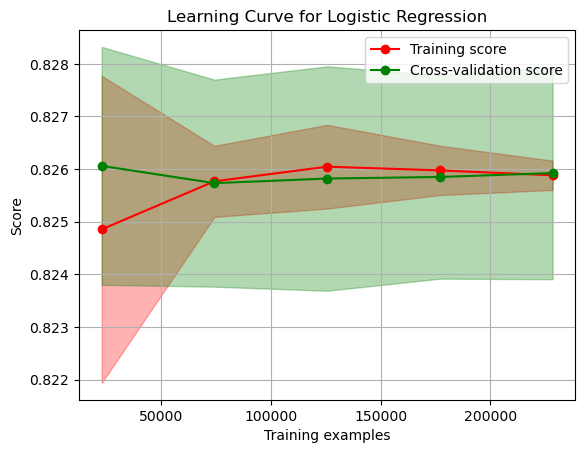

In [ ]:
# Get the learning curve plot
train_sizes, train_scores, test_scores = learning_curve(lr_model, features, labels, cv=10,
                                                            train_sizes=np.linspace(.1, 1.0, 5),
                                                            scoring='f1_weighted', shuffle=True, random_state=42)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
					train_scores_mean + train_scores_std, alpha=0.3, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
					test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
			label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
			label="Cross-validation score")

plt.legend(loc='best')
plt.show()

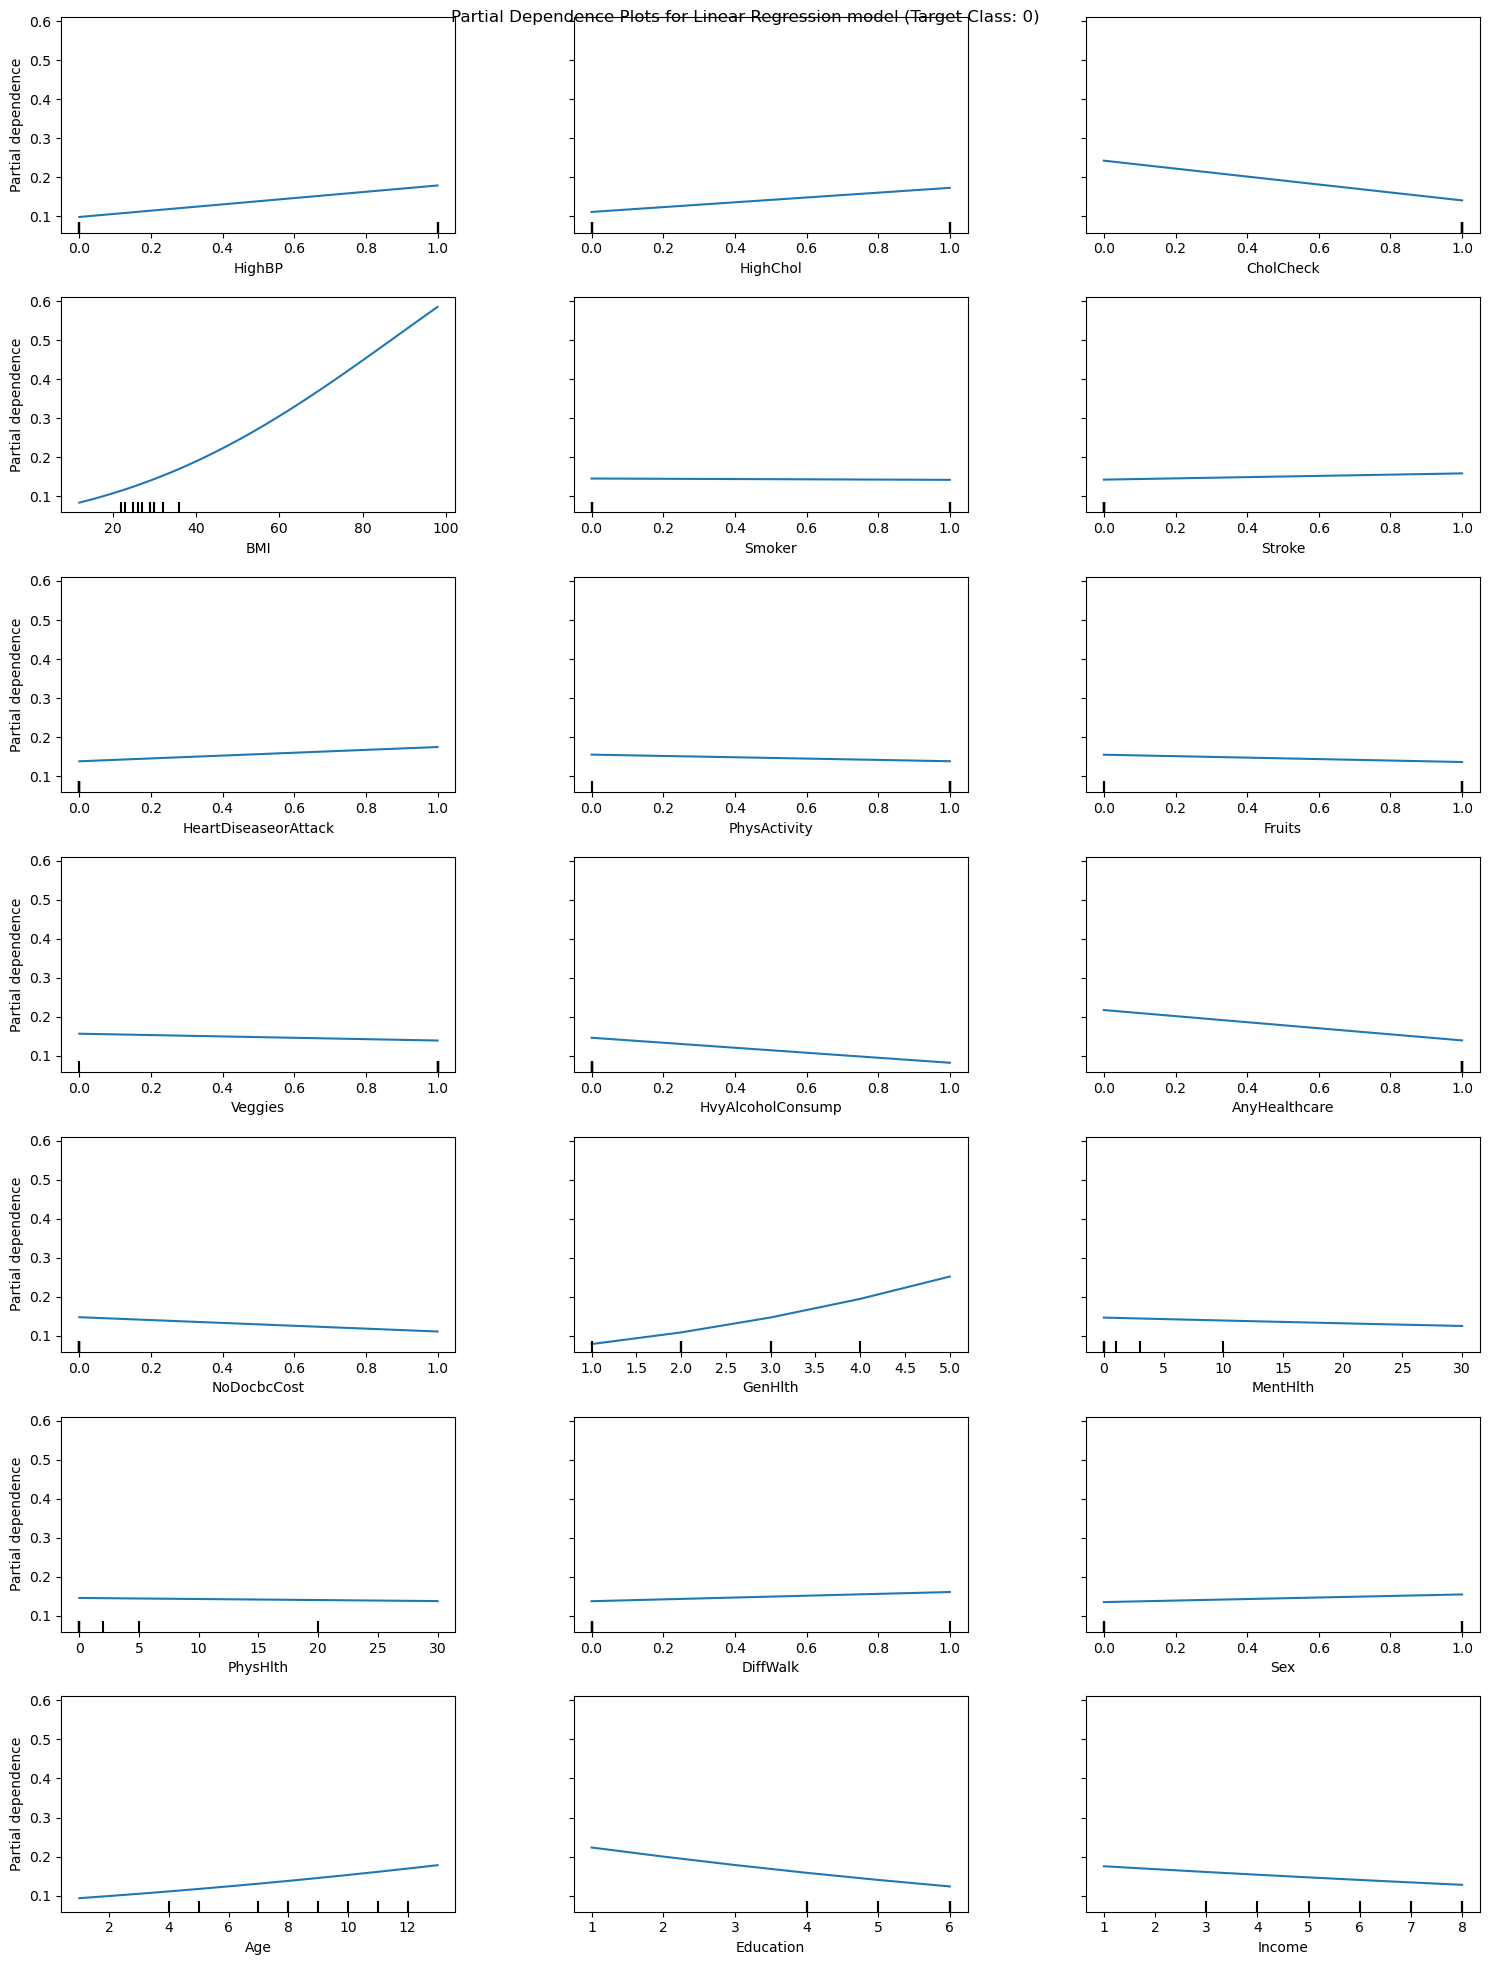

In [ ]:
# Model's Features Dependencies
'''
This is to show the relationship between a feature and the model's predictions (with all other features constant)

'''
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(15, 20), )
target_class = 0  # specify the target class
PartialDependenceDisplay.from_estimator(
	lr_model, features, features.columns, ax=ax, target=target_class)

# Increase spacing between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle(f'Partial Dependence Plots for Linear Regression model (Target Class: {target_class})')
fig.tight_layout()
plt.show()


### B-Hyper parameters Tuning

##### 1. class_weight
 can be dict or ‘balanced’, The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
	default=None

In [ ]:

lr_model = LogisticRegression(class_weight='balanced',max_iter=40000)
lr_model.fit(x_train, y_train)


# Evaluate model
y_pred_train = lr_model.predict(x_train)
y_pred_test = lr_model.predict(x_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print("Training Accuracy:%.4f " % (train_accuracy*100))
print("Testing Accuracy:%.4f " % (test_accuracy*100))
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", class_report)


#ROC-AUC Curve
# predict probabilities and keep postive outcomes only
probs = lr_model.predict_proba(x_test)
probs = probs[:, 1]

# AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

# create a KFold object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# perform cross-validation
scores = cross_val_score(lr_model, features, labels, cv=kf)

print(f"Accuracy after applying cross validation: {scores.mean():.5f} (+/- {scores.std():.5f})")



Training Accuracy:72.3673 
Testing Accuracy:72.2643 
Confusion Matrix: 
 [[47044 18561]
 [ 2547  7952]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82     65605
           1       0.30      0.76      0.43     10499

    accuracy                           0.72     76104
   macro avg       0.62      0.74      0.62     76104
weighted avg       0.86      0.72      0.76     76104

AUC: 0.811
Accuracy after applying cross validation: 0.72307 (+/- 0.00300)


##### 2. solver
Algorithm to use in the optimization problem. {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
‘liblinear’ is limited to one-versus-rest schemes.
‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.
	default=’lbfgs’

In [42]:
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
score =[]

for solver in solvers:
    print(f"Training with solver: {solver}")
    lr_model = LogisticRegression(class_weight='balanced',solver=solver, max_iter=10000)
    lr_model.fit(x_train, y_train)


	# Evaluate model
    y_pred_train = lr_model.predict(x_train)
    y_pred_test = lr_model.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    print("Training Accuracy:%.4f " % (train_accuracy*100))
    print("Testing Accuracy:%.4f " % (test_accuracy*100))
    print("Confusion Matrix: \n", conf_matrix)


	#ROC-AUC Curve
	# predict probabilities and keep postive outcomes only
    probs = lr_model.predict_proba(x_test)
    probs = probs[:, 1]

	# AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    
# create a KFold object
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # perform cross-validation
    scores = cross_val_score(lr_model, features, labels, cv=kf)
    
    score.append(f"{scores.mean():.5f}  (+/- {scores.std():.5f})")


    print('----------------------------------------------------------------')

pd.DataFrame({'solver': solvers, 'mean scores': score})

Training with solver: newton-cg
Training Accuracy:72.3668 
Testing Accuracy:72.2590 
Confusion Matrix: 
 [[47041 18564]
 [ 2548  7951]]
AUC: 0.811
----------------------------------------------------------------
Training with solver: lbfgs
Training Accuracy:72.3628 
Testing Accuracy:72.2630 
Confusion Matrix: 
 [[47042 18563]
 [ 2546  7953]]
AUC: 0.811
----------------------------------------------------------------
Training with solver: sag
Training Accuracy:72.3555 
Testing Accuracy:72.2511 
Confusion Matrix: 
 [[47033 18572]
 [ 2546  7953]]
AUC: 0.811
----------------------------------------------------------------
Training with solver: saga
Training Accuracy:72.3656 
Testing Accuracy:72.2630 
Confusion Matrix: 
 [[47044 18561]
 [ 2548  7951]]
AUC: 0.811
----------------------------------------------------------------


,solver,mean scores
0,newton-cg,0.72309 (+/- 0.00302)
1,lbfgs,0.72307 (+/- 0.00299)
2,sag,0.72307 (+/- 0.00299)
3,saga,0.72309 (+/- 0.00302)


##### 3. Penalty
Specifies the norm used in the penalization. It can be one of {'l1', 'l2', 'elasticnet', 'none'}.
'elasticnet' allows a combination of L1 and L2 penalties
	default=’l2’

Note: type of solvers compatability with penalty are:

		‘lbfgs’ - [‘l2’, None]
		‘newton-cg’ - [‘l2’, None]
		‘sag’ - [‘l2’, None]
		‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]


In [44]:
penalties = ['l2']
score =[]

for penalty in penalties:
    print(f"Training with Penalty: {penalty}")
    lr_model = LogisticRegression(class_weight='balanced',penalty=penalty, solver = 'lbfgs', max_iter=40000)
    lr_model.fit(x_train, y_train)


	# Evaluate model
    y_pred_train = lr_model.predict(x_train)
    y_pred_test = lr_model.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    class_report = classification_report(y_test, y_pred_test)
    
    print("Training Accuracy:%.4f" % (train_accuracy*100))
    print("Testing Accuracy:%.4f" % (test_accuracy*100))
    print("Confusion Matrix: \n", conf_matrix)
    print("Classification Report: \n", class_report)


	#ROC-AUC Curve
	# predict probabilities and keep postive outcomes only
    probs = lr_model.predict_proba(x_test)
    probs = probs[:, 1]

	# AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    
	# create a KFold object
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # perform cross-validation
    scores = cross_val_score(lr_model, features, labels, cv=kf)
    
    score.append(f"{scores.mean():.5f}  (+/- {scores.std():.5f})")
	
    print('----------------------------------------------------------------')

pd.DataFrame({'Penalty': penalties, 'mean scores': score})



Training with Penalty: l2
Training Accuracy:72.3628
Testing Accuracy:72.2630
Confusion Matrix: 
 [[47042 18563]
 [ 2546  7953]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82     65605
           1       0.30      0.76      0.43     10499

    accuracy                           0.72     76104
   macro avg       0.62      0.74      0.62     76104
weighted avg       0.86      0.72      0.76     76104

AUC: 0.811
----------------------------------------------------------------


,Penalty,mean scores
0,l2,0.72307 (+/- 0.00299)


##### 4. C
 Inverse of regularization strength; smaller values specify stronger regularization. Regularization helps prevent overfitting by penalizing large coefficients.
	default=1.0

In [45]:
Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
score =[]

for c in Cs:
    print(f"Training with C (Inverse regularization strength): {c}")
    lr_model = LogisticRegression(class_weight='balanced',C=c, penalty='l2', solver='lbfgs', max_iter=40000)
    lr_model.fit(x_train, y_train)


	# Evaluate model
    y_pred_train = lr_model.predict(x_train)
    y_pred_test = lr_model.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    print("Training Accuracy:%.4f " % (train_accuracy*100))
    print("Testing Accuracy:%.4f " % (test_accuracy*100))
    print("Confusion Matrix: \n", conf_matrix)


	#ROC-AUC Curve
	# predict probabilities and keep postive outcomes only
    probs = lr_model.predict_proba(x_test)
    probs = probs[:, 1]

	# AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    
# create a KFold object
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # perform cross-validation
    scores = cross_val_score(lr_model, features, labels, cv=kf)
    
    score.append(f"{scores.mean():.5f}  (+/- {scores.std():.5f})")


    print('----------------------------------------------------------------')

pd.DataFrame({'C': Cs, 'mean scores': score})

Training with C (Inverse regularization strength): 0.1
Training Accuracy:72.3628 
Testing Accuracy:72.2643 
Confusion Matrix: 
 [[47046 18559]
 [ 2549  7950]]
AUC: 0.811
----------------------------------------------------------------
Training with C (Inverse regularization strength): 0.2
Training Accuracy:72.3662 
Testing Accuracy:72.2643 
Confusion Matrix: 
 [[47046 18559]
 [ 2549  7950]]
AUC: 0.811
----------------------------------------------------------------
Training with C (Inverse regularization strength): 0.3
Training Accuracy:72.3639 
Testing Accuracy:72.2630 
Confusion Matrix: 
 [[47044 18561]
 [ 2548  7951]]
AUC: 0.811
----------------------------------------------------------------
Training with C (Inverse regularization strength): 0.4
Training Accuracy:72.3639 
Testing Accuracy:72.2656 
Confusion Matrix: 
 [[47045 18560]
 [ 2547  7952]]
AUC: 0.811
----------------------------------------------------------------
Training with C (Inverse regularization strength): 0.5
Train

,C,mean scores
0,0.1,0.72309 (+/- 0.00303)
1,0.2,0.72308 (+/- 0.00303)
2,0.3,0.72308 (+/- 0.00304)
3,0.4,0.72312 (+/- 0.00299)
4,0.5,0.72308 (+/- 0.00304)
5,0.6,0.72306 (+/- 0.00303)
6,0.7,0.72312 (+/- 0.00302)
7,0.8,0.72307 (+/- 0.00300)


## Final Model


Training Accuracy:73.8542 
Testing Accuracy:74.1162 
Confusion Matrix: 
 [[46872 18722]
 [15186 50221]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.71      0.73     65594
           1       0.73      0.77      0.75     65407

    accuracy                           0.74    131001
   macro avg       0.74      0.74      0.74    131001
weighted avg       0.74      0.74      0.74    131001



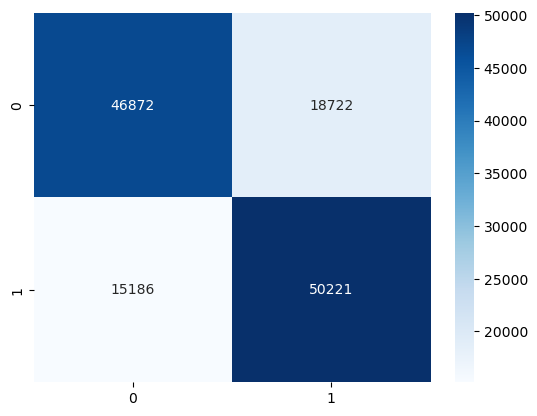

AUC: 0.7860


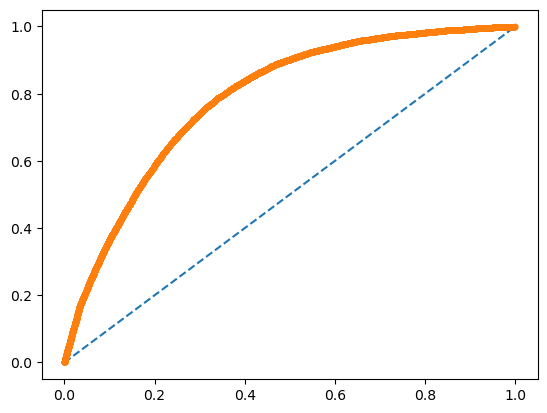

Accuracy after applying cross validation: 0.73906 (+/- 0.00238)


In [46]:

lr_model = LogisticRegression(class_weight='balanced', C=0.4, penalty='l2', solver='lbfgs', max_iter=40000)
lr_model.fit(x_train_resampled, y_train_resampled)


# Evaluate model
y_pred_train = lr_model.predict(x_train_resampled)
y_pred_test = lr_model.predict(x_test_resampled)

train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test_resampled, y_pred_test)
conf_matrix = confusion_matrix(y_test_resampled, y_pred_test)
class_report = classification_report(y_test_resampled, y_pred_test)

print("Training Accuracy:%.4f " % (train_accuracy*100))
print("Testing Accuracy:%.4f " % (test_accuracy*100))
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", class_report)


sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

#ROC-AUC Curve
# predict probabilities and keep postive outcomes only
probs = lr_model.predict_proba(x_test)
probs = probs[:, 1]

# AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.show()


# create a KFold object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# perform cross-validation
scores = cross_val_score(lr_model, features_resampled, labels_resampled, cv=kf)

print(f"Accuracy after applying cross validation: {scores.mean():.5f} (+/- {scores.std():.5f})")


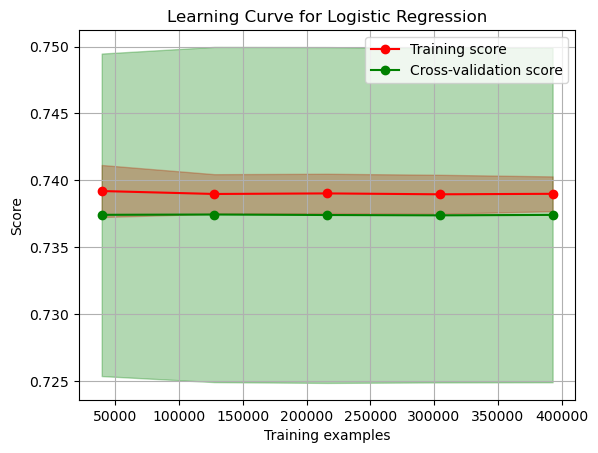

In [47]:
# Get the learning curve plot
train_sizes, train_scores, test_scores = learning_curve(lr_model, features_resampled, labels_resampled, cv=10,
                                                            train_sizes=np.linspace(.1, 1.0, 5),
                                                            scoring='f1_weighted', shuffle=True, random_state=42)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
					train_scores_mean + train_scores_std, alpha=0.3, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
					test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
			label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
			label="Cross-validation score")

plt.legend(loc='best')
plt.show()